The challenge: 

this competition is about forecasting daily sales of produccts in walmart for next 28 days (forecast 28 days ahead). The dataset that is provided includes the store details (in CA, TX, and WI), prices of products, promotions of the products and special events. 
- sales_prices: this data set includes the store id, item id, the sales period (month,year,and week) and sales price
- calender: includes all the special events, Supplement Nutrition Assistance Program (SNAP) for each stores
- sales_train_val: ids and the amount of products sold each day

Point: 
- at the end of day, business goals are to improve the statisfication of the customers, increase the revenues and find strategies that will help the company grow. 
- will not able to forecast using the price because the future price are not given so I have to use the historical sales to forecast it 
 

Hypothesis: 
1. the stores in 3 different states will have different sales, so creating a training set with all three states would create many errors when forecasting for almost two months 
2. Creating training set for each states may have better accuracy 



In [1]:
from datetime import datetime, timedelta
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import gc
import lightgbm as lgb
import warnings 


plt.style.use('ggplot')

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
#memory reduce usage was obtained from kaggle user
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [2]:
h = 28 #28 days ahead forecast 
lst_day = 1913
max_lag = 420
fday = datetime(2016, 4, 25)

#public evaluation 
public_first = 1914
public_last = 1941

##evaluation (private)
eval_first = 1942
eval_last = 1969


## Data Cleaning and Wranging 
- Create datasets 
- Create train and test sets 
- split the dates for train and tests 

In [3]:

def create_df(train_set = True, frst_day = 350): 
    
    calender_dtype={"event_name_1": "category", "event_name_2": "category", "event_type_1": "category", 
         "event_type_2": "category", "weekday": "category", 'wm_yr_wk': 'int16', "wday": "int16",
        "month": "int16", "year": "int16", "snap_CA": "float32", 'snap_TX': 'float32', 'snap_WI': 'float32' }
    
    price_dtype = {"store_id": "category", "item_id": "category", "wm_yr_wk": "int16","sell_price":"float32" }

    #prices of products 
    sales = pd.read_csv('sell_prices.csv', dtype= price_dtype)
    
    for col, col_type in price_dtype.items(): 
        if col_type == 'category': 
            sales[col] = sales[col].cat.codes.astype("int16")
            sales[col] -= sales[col].min()
    
    #calender dataset 
    calender = pd.read_csv('calendar.csv', dtype= calender_dtype)
    calender.date = pd.to_datetime(calender.date)
    
    for col, col_types in calender_dtype.items():
        if col_types == 'category': 
            calender[col] = calender[col].cat.codes.astype("int16")
            calender[col] -= calender[col].min()
    
    #sales_train_val
    start_day = max(1 if train_set else lst_day-max_lag,frst_day)
    numstype = [f"d_{day}" for day in range(start_day, lst_day+1) if train_set == True] #what if its false?
    colstype = ['id', "store_id", 'state_id', 'item_id', 'cat_id', 'dept_id'] #'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
    
    dtype = {num: 'float32' for num in numstype}
    dtype.update({col: "category" for col in colstype}) 
    data_set = pd.read_csv('sales_train_validation.csv', usecols = numstype + colstype, dtype = dtype)
    
    no_encoding = ['id', 'state_id']
    
    for col in colstype: 
        if col != 'id': 
            data_set[col] = data_set[col].cat.codes.astype("int16")
            
    
    if train_set != True:  #test set for 28days 
        for day in range(lst_day+1, lst_day+ 28 +1):
            data_set[f"d_{day}"] = np.nan
        
    data_set = pd.melt(data_set, id_vars = ['id', 'store_id', 'item_id', 'cat_id', 'state_id','dept_id'] , var_name = "d", value_name = 'Sales')
    
    data_set = data_set.merge(calender, on = "d", copy = False)
    
    data_set = data_set.merge(sales, on = ['store_id', 'item_id', 'wm_yr_wk'], copy = False)
    gc.collect()
    
    return data_set


In [5]:
%%time 
df = create_df(train_set=True)

CPU times: user 1min 37s, sys: 11.5 s, total: 1min 48s
Wall time: 1min 50s


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40718219 entries, 0 to 40718218
Data columns (total 21 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            category      
 1   store_id      int16         
 2   item_id       int16         
 3   cat_id        int16         
 4   dept_id       int16         
 5   d             object        
 6   Sales         float32       
 7   date          datetime64[ns]
 8   wm_yr_wk      int16         
 9   weekday       int16         
 10  wday          int16         
 11  month         int16         
 12  year          int16         
 13  event_name_1  int16         
 14  event_type_1  int16         
 15  event_name_2  int16         
 16  event_type_2  int16         
 17  snap_CA       float32       
 18  snap_TX       float32       
 19  snap_WI       float32       
 20  sell_price    float32       
dtypes: category(1), datetime64[ns](1), float32(5), int16(13), object(1)
memory usage: 4.0+ GB


In [ ]:
#groupby 
df_copy = df.copy()
ca_stores = df_copy.groupby(['store_id'])['0','1','2']


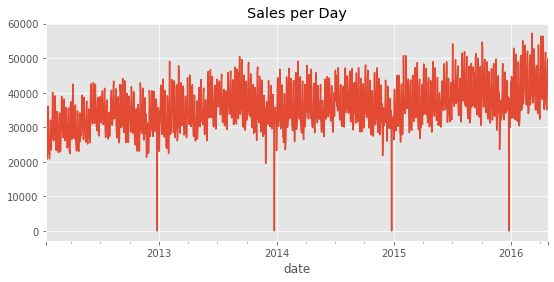

In [6]:
Sales_per_day = df.groupby(['date'])['Sales'].sum()
Sales_per_day.plot(figsize = (9,4), title = 'Sales per Day')
plt.show()


- the Sales of items seems to have mean reversion and covariance stationary. We can try to use ARIMA model or classical ML model to try to forecast the sales for next 28 days 

In [7]:
#looking at each states, CA: item_id: 0-3 

  

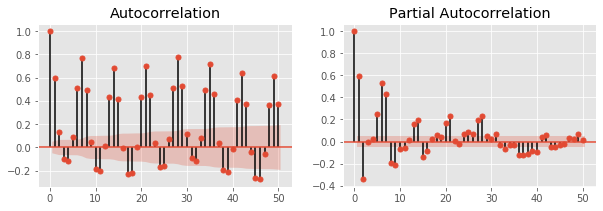

In [8]:
sales_per_day = Sales_per_day.reset_index()


fig, ax = plt.subplots(1,2,figsize=(10,3))
plot_acf(sales_per_day['Sales'], lags = 50 ,ax = ax[0]);
plot_pacf(sales_per_day["Sales"], lags = 50,ax = ax[1]);

#the past sales are correlated with the sales in time T.
#Also, PACf shows the past lags are significant in explaining the sales of today




The correlation plot shows the lags are helpful in explaining the today's sales. More importantly, the pattern of the sales are present 

## Feature engineering 
### main questions: how we capture the trend, and seasonality? How do we reduce the memory space? 
- create trend features 
- create seasonality features 
- lags,and rolling mean 
    - the model will use the past observation of 7 days, which is a week, to make predictions. 
    - will predict 28 days ahead 
    - Rolling mean vs expending window: 
        - expending window takes the past observation and the predictions t+1 to predict t+2 and so on 
        

Window statistics:
- Max/min value of series in a window
- Average/median value in a window
- Window variance etc.
- Date and time features:
- Minute of an hour, hour of a day, day of the week, and so on
- Is this day a holiday? Maybe there is a special event? Represent that as a boolean feature
        

In [9]:
##create features (lags, expending windows, 1 and 0 for events, and days,months and years)
##each day is faster 

def create_features(dt): 
    
    lags = [7,14,28]
    lags_col = [f"sales_lag_{lag}" for lag in lags]
    for lag, lag_col in zip(lags,lags_col): 
        #dt.loc[dt.date == day, lag_col] = dt.loc[dt.date == day-timedelta(days=lag), 'sales'].values 
        dt[lag_col] = dt[['id', 'Sales']].groupby(['id'])['Sales'].shift(lag)
        
    ##rolling mean 
    windows = [7,28]
    for window in windows: 
        for lag, lag_col in zip(lags, lags_col):  

            dt[f"rollM_{window}_{lag}"] = dt[['id', lag_col]].groupby('id')[lag_col].transform(lambda x : x.rolling(window).mean())
           # dt[f"rollMin_{window}_{lag}"] = dt[['id', lag_col]].groupby('id')[lag_col].transform(lambda x : x.rolling(window).min())
           # dt[f"rollMax_{window}_{lag}"] = dt[['id', lag_col]].groupby('id')[lag_col].transform(lambda x : x.rolling(window).max())
    
   # del dt['wm_yr_wk'], dt['d']
    gc.collect()  
    
    date_features = {
        
        "wday": "weekday",
        "week": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",
#         "ime": "is_month_end",
#         "ims": "is_month_start",
    }
    
#     dt.drop(["d", "wm_yr_wk", "weekday"], axis=1, inplace = True)
    
    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in dt.columns:
            dt[date_feat_name] = dt[date_feat_name].astype("int16")
        else:
            dt[date_feat_name] = getattr(dt["date"].dt, date_feat_func).astype("int16")
    

In [10]:
%%time
create_features(df)

CPU times: user 3min 3s, sys: 1min 5s, total: 4min 9s
Wall time: 3min 12s


### Splitting the dataset into training and validation (last 28 days) 

In [11]:
 
def train_val(df): 
    
    last_train = datetime(2016,4,24) #28 days before the last day of training set (couldnt use timedelta)

    train_set = df[df['date'] <= last_train -timedelta(h)]
    val_set = df[df['date'] > last_train- timedelta(h)]

    print(f"trainset first date:_{train_set.date.min()}")
    print(f"trainset last date:_{train_set.date.max()}")
    print(f"val_set first date:_{val_set.date.min()}")
    print(f"val_set last date:_{val_set.date.max()}")

  
   # del train_set['id'], val_set['id'], train_set['date'], val_set['date']
    gc.collect()
    
    #y_train = train_set[Target]
   # x_train = train_set.drop(train_set[Target])
    
    return train_set, val_set

In [12]:
train_set, val_set = train_val(df)

trainset first date:_2012-01-13 00:00:00
trainset last date:_2016-03-27 00:00:00
val_set first date:_2016-03-28 00:00:00
val_set last date:_2016-04-24 00:00:00


In [13]:
id_1 = train_set[train_set['id'] == 'HOBBIES_1_002_CA_1_validation']
id_1[['sales_lag_7', 'rollM_7_7']].head(20)

,sales_lag_7,rollM_7_7
0,NaN,NaN
16856,NaN,NaN
16857,NaN,NaN
16858,NaN,NaN
16859,NaN,NaN
16860,NaN,NaN
16861,NaN,NaN
16862,0.0,NaN
135380,0.0,NaN
135381,0.0,NaN


In [14]:
train_set.shape, val_set.shape

((39864499, 33), (853720, 33))

In [15]:
train_set.head()

,id,store_id,item_id,cat_id,dept_id,d,Sales,date,wm_yr_wk,weekday,...,sales_lag_28,rollM_7_7,rollM_7_14,rollM_7_28,rollM_28_7,rollM_28_14,rollM_28_28,week,quarter,mday
0,HOBBIES_1_002_CA_1_validation,0,1,0,0,d_350,0.0,2012-01-13,11150,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1,13
1,HOBBIES_1_004_CA_1_validation,0,3,0,0,d_350,2.0,2012-01-13,11150,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1,13
2,HOBBIES_1_005_CA_1_validation,0,4,0,0,d_350,0.0,2012-01-13,11150,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1,13
3,HOBBIES_1_008_CA_1_validation,0,7,0,0,d_350,0.0,2012-01-13,11150,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1,13
4,HOBBIES_1_009_CA_1_validation,0,8,0,0,d_350,2.0,2012-01-13,11150,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1,13


In [16]:
catogery = ['store_id', 'item_id', 'cat_id', 'dept_id'] + ["event_name_1", "event_name_2", "event_type_1", "event_type_2"]
drop_var = ['id', 'date','d', 'Sales', "wm_yr_wk", 'weekday']
train_cols = df.columns[~df.columns.isin(drop_var)]

Target = 'Sales'

ytrain = train_set[Target]
xtrain = train_set[train_cols]

y_val = val_set[Target]
x_val = val_set[train_cols]



In [17]:
xtrain.info(), x_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39864499 entries, 0 to 40016943
Data columns (total 27 columns):
store_id        int16
item_id         int16
cat_id          int16
dept_id         int16
wday            int16
month           int16
year            int16
event_name_1    int16
event_type_1    int16
event_name_2    int16
event_type_2    int16
snap_CA         float32
snap_TX         float32
snap_WI         float32
sell_price      float32
sales_lag_7     float32
sales_lag_14    float32
sales_lag_28    float32
rollM_7_7       float32
rollM_7_14      float32
rollM_7_28      float32
rollM_28_7      float32
rollM_28_14     float32
rollM_28_28     float32
week            int16
quarter         int16
mday            int16
dtypes: float32(13), int16(14)
memory usage: 3.3 GB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 853720 entries, 39803521 to 40718218
Data columns (total 27 columns):
store_id        853720 non-null int16
item_id         853720 non-null int16
cat_id          8

(None, None)

In [18]:
xtr = lgb.Dataset(xtrain, label = ytrain, categorical_feature=catogery, free_raw_data = False)
xval = lgb.Dataset(x_val, label = y_val, categorical_feature= catogery, free_raw_data = False)


In [19]:
params = {
        "objective" : "poisson",
        "metric" :"rmse",
        "force_row_wise": True,
        "learning_rate" : 0.071,
         "sub_feature" : 0.8,
        "sub_row" : 0.75,
        "bagging_freq" : 1,
        "lambda_l2" : 0.1,
#         "nthread" : 4
        "metric": ["rmse"],
    'verbosity': 1,
    'num_iterations' : 1600,
    'num_leaves': 128, #128
    "min_data_in_leaf": 100, #200
}

In [20]:
%%time

#t_lgb = lgb.train(params, xtr, num_boost_round=100, valid_sets=xval, verbose_eval=5, early_stopping_rounds=100)
#valid_0's rmse: 2.03225

lgb_model3 = lgb.train(params, xtr, valid_sets=xval, verbose_eval=5, early_stopping_rounds=200)
#valid_0's rmse: 2.03256 - model2
#valid_0's rmse: 2.00176 - model3
# 2.0031

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds
[5]	valid_0's rmse: 3.13026
[10]	valid_0's rmse: 2.83514
[15]	valid_0's rmse: 2.61438
[20]	valid_0's rmse: 2.45056
[25]	valid_0's rmse: 2.32982
[30]	valid_0's rmse: 2.24214
[35]	valid_0's rmse: 2.17934
[40]	valid_0's rmse: 2.1346
[45]	valid_0's rmse: 2.10283
[50]	valid_0's rmse: 2.0804
[55]	valid_0's rmse: 2.0642
[60]	valid_0's rmse: 2.05327
[65]	valid_0's rmse: 2.04534
[70]	valid_0's rmse: 2.03985
[75]	valid_0's rmse: 2.03552
[80]	valid_0's rmse: 2.03238
[85]	valid_0's rmse: 2.0301
[90]	valid_0's rmse: 2.02813
[95]	valid_0's rmse: 2.02742
[100]	valid_0's rmse: 2.02665
[105]	valid_0's rmse: 2.02563
[110]	valid_0's rmse: 2.02494
[115]	valid_0's rmse: 2.02427
[120]	valid_0's rmse: 2.02393
[125]	valid_0's rmse: 2.02334
[130]	valid_0's rmse: 2.0227
[135]	valid_0's rmse: 2.02236
[140]	valid_0's rmse: 2.02205
[145]	valid_0's rmse: 2.0219
[150]	valid_0's rmse: 2.0221
[155]	valid_0's rmse: 2.0215
[160]	valid_0's rmse: 2.02115
[165]	

[1360]	valid_0's rmse: 2.00094
[1365]	valid_0's rmse: 2.0014
[1370]	valid_0's rmse: 2.00125
[1375]	valid_0's rmse: 2.00121
[1380]	valid_0's rmse: 2.0012
[1385]	valid_0's rmse: 2.00116
[1390]	valid_0's rmse: 2.0012
[1395]	valid_0's rmse: 2.00124
[1400]	valid_0's rmse: 2.00118
[1405]	valid_0's rmse: 2.00103
[1410]	valid_0's rmse: 2.00098
[1415]	valid_0's rmse: 2.0009
[1420]	valid_0's rmse: 2.00092
[1425]	valid_0's rmse: 2.00087
[1430]	valid_0's rmse: 2.00088
[1435]	valid_0's rmse: 2.0009
[1440]	valid_0's rmse: 2.0009
[1445]	valid_0's rmse: 2.00098
[1450]	valid_0's rmse: 2.00099
[1455]	valid_0's rmse: 2.00098
[1460]	valid_0's rmse: 2.00103
[1465]	valid_0's rmse: 2.00104
[1470]	valid_0's rmse: 2.0011
[1475]	valid_0's rmse: 2.00106
[1480]	valid_0's rmse: 2.00096
[1485]	valid_0's rmse: 2.00096
[1490]	valid_0's rmse: 2.00096
[1495]	valid_0's rmse: 2.00094
[1500]	valid_0's rmse: 2.00091
[1505]	valid_0's rmse: 2.00096
[1510]	valid_0's rmse: 2.00094
[1515]	valid_0's rmse: 2.0007
[1520]	valid_0's

In [21]:
lgb_model3.save_model("model5.lgb")

In [22]:
model2 = lgb.Booster(model_file='model5.lgb')

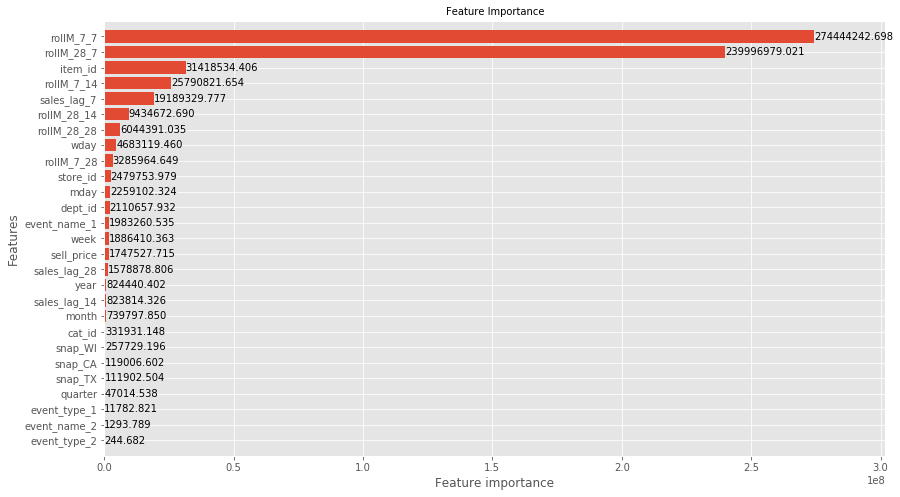

In [23]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(14,8))
lgb.plot_importance(model2, max_num_features=50, height=0.8, ax=ax, importance_type='gain')
plt.title("Feature Importance", fontsize=10)
plt.show()

In [24]:
import graphviz
%matplotlib notebook

#data = lgb.create_tree_digraph(t_lgb, tree_index = 20,show_info=['split_gain'])
#data = lgb.plot_tree(t_lgb,show_info=['split_gain'])
#graph = graphviz.Source(data)  
#graph 

In [26]:

alpha = [1.028]
test_set = create_df(False) 

ts = test_set.copy()  # just copy
cols = [f"F{i}" for i in range(1, 29)]

for tdelta in range(0, 28):
    day = fday + timedelta(days=tdelta)
    print(tdelta, day.date())
        
    test = ts[(ts.date >= day - timedelta(days = max_lag)) & (ts.date <= day)].copy()
    create_features(test)
        
    test = test.loc[test.date == day, train_cols]
    ts.loc[ts.date == day, "Sales"] = alpha *model2.predict(test)  # magic multiplier by kyakovlev




0 2016-04-25


KeyboardInterrupt: 

In [ ]:
test_sub = ts.loc[ts.date >= fday, ["id", "Sales"]].copy()
test_sub["F"] = [f"F{rank}" for rank in test_sub.groupby("id")["id"].cumcount()+1]
test_sub = test_sub.set_index(["id", "F"]).unstack()["Sales"][cols].reset_index()
    
#test_sub.fillna(0., inplace=True)
test_sub.sort_values("id", inplace=True)
test_sub.reset_index(drop=True, inplace=True)
test_sub.to_csv(f"submission4.csv", index=False)

In [ ]:
sub2 = test_sub.copy()
sub2["id"] = sub2["id"].str.replace("validation$", "evaluation")
sub = pd.concat([test_sub, sub2], axis=0, sort=False)
sub.to_csv("submissionF1.csv",index=False)

In [ ]:
forecast_sales = ts.groupby(['date'])['Sales'].sum()


In [ ]:
%matplotlib notebook
ax1 = Sales_per_day.plot(figsize =(9,4))
forecast_sales.plot(ax = ax1)

